In [1]:
import numpy as np
from scipy.io import savemat
import sys
import kernel_class
import linkgp
from emulation import emulator

#from dgpsi import dgp, kernel, combine, lgp, path, emulator
from dgp import dgp
from kernel_class import kernel
from kernel_class import combine
from likelihood_class import Hetero

from SI_UCB_stable import DGPSI_LCB_stable

from eval_functions_28Apr2022 import *
import time
from smt.sampling_methods import LHS

from LCB_DGPSI_stable import lcb_stable

In [2]:
d = 1
actual_optimum = -1.0578 
folder = './art1/'
max_steps = 15
x_lb = np.zeros((d,1))
x_ub = np.ones((d,1))

xlimits = np.hstack((x_lb,x_ub))

In [3]:
layer1=[kernel(length=np.array([1]),name='sexp')]
layer2=[kernel(length=np.array([1]),name='sexp')]
all_layer_init=combine(layer1,layer2) 

In [7]:
N_predict = 50
bag_size = 30

max_iters = 5
m = 100
N_train = 20
n = 3
new_n = max_steps - n


In [5]:
with_bags = False

f = art1
folder = "./theory/"
label = "wo_bag"
total_bags = 1

current_opt = np.empty((max_iters,n+new_n))
regret = np.empty((max_iters,n+new_n))
time_elapsed = np.empty((max_iters,n+new_n))
current_opt[:] = np.NaN
regret[:] = np.NaN
time_elapsed[:] = np.NaN 



for iters in range(max_iters):
    seed = iters
    all_layer = all_layer_init

    np.random.seed(seed) 
    lhs_sampling = LHS(xlimits = xlimits,random_state = seed, criterion = 'maximin')
    x = lhs_sampling(n)
    y = f(x).reshape(-1,1)

    y_std = np.std(y)

    y = y/y_std

    current_opt[iters,n-1] = np.amin(y)*y_std
    regret[iters,n-1] = current_opt[iters,n-1] - actual_optimum

    print('Iteration ', iters,'\nRegret Start = ',regret[iters,n-1])

    for i in range(n,n+new_n):
        start_t = time.time()
        np.random.seed(1000*iters + 2*i)  

        model=dgp(x,[y],1000*iters + 2*i,all_layer = all_layer,check_rep = False)

        if(i==n):
            model.initialize(seed = 1000*iters + 2*i)
            model.train(N=100,disable = True)
            all_layer=model.estimate()
        else:
            model.train(N=N_train,disable = True)
            all_layer=model.estimate(burnin = int(N_train/2))

        emu=emulator(all_layer,N=N_predict,nb_parallel = True)

        np.random.seed(1000*iters + 2*i) 
        #xx = np.random.uniform(low = xlimits[:,0],high = xlimits[:,1],size = (m,d))
       
        xx = np.random.uniform(low = xlimits[:,0],high = xlimits[:,1],size = (m,d))

        res = emu.ppredict(x=np.reshape(xx,(-1,d)), sample_size=1, method='mean_var',chunk_num = 28,core_num = 28)


        mu_all = np.transpose(np.array(res[2]))
        var_all = np.transpose(np.array(res[3]))

        yy = lcb_stable(mu_all = mu_all,var_all = var_all,n=i,d=d)
        minlcb_idx = np.argmin(yy)
        x0 = xx[minlcb_idx,:]

        new_x = np.reshape(x0,(1,d))
        x = np.append(x,new_x,axis=0)
        y_new = (f(new_x)/y_std).reshape(-1,1)
        y = np.append(y,y_new,axis=0)

        if (y_new < (current_opt[iters,i-1])/y_std):
            current_opt[iters,i] = y_new*y_std
            regret[iters,i] = current_opt[iters,i] - actual_optimum
        else:
            current_opt[iters,i] = current_opt[iters,i-1]
            regret[iters,i] = regret[iters,i-1]
        end_t = time.time()
        time_elapsed[iters,i] = end_t - start_t

        print ('i = ',i ,' Regret Current = ',regret[iters,i],end="\r")
    #print('Time Lapsed = ',time.time() - init_t)
        # if(regret[iters,i]<0.00001):
        #     regret[iters,i+1:] = regret[iters,i]
        #     break
        

    print("\n")
    del x
    del y
    del model

    mdic = {"current_opt_DGPUCB": current_opt,"regret_DGPUCB": regret, "runtime_DGPUCB":time_elapsed}
    savemat(folder+label+"_DGPUCB_"+ str(time.asctime(time.localtime(time.time())))+"_iter"+str(iters)+".mat", mdic)

Iteration  0 
Regret Start =  0.2541312145451209
i =  14  Regret Current =  0.05835285959661296

Iteration  1 
Regret Start =  0.011552064078438562
i =  14  Regret Current =  -2.3759175822091194e-05

Iteration  2 
Regret Start =  0.03956994445980078
i =  14  Regret Current =  -2.432127754681268e-05

Iteration  3 
Regret Start =  0.006027791669572569
i =  14  Regret Current =  -2.285600095230933e-05

Iteration  4 
Regret Start =  0.022919303704211025
i =  14  Regret Current =  2.359568721410632e-05



In [8]:
with_bags = True

f = art1
folder = "./theory/"
label = "with_bag"
total_bags = 400

current_opt = np.empty((max_iters,n+new_n))
regret = np.empty((max_iters,n+new_n))
time_elapsed = np.empty((max_iters,n+new_n))
current_opt[:] = np.NaN
regret[:] = np.NaN
time_elapsed[:] = np.NaN 



for iters in range(max_iters):
    seed = iters
    all_layer = all_layer_init

    np.random.seed(seed) 
    lhs_sampling = LHS(xlimits = xlimits,random_state = seed, criterion = 'maximin')
    x = lhs_sampling(n)
    y = f(x).reshape(-1,1)

    y_std = np.std(y)

    y = y/y_std

    current_opt[iters,n-1] = np.amin(y)*y_std
    regret[iters,n-1] = current_opt[iters,n-1] - actual_optimum

    print('Iteration ', iters,'\nRegret Start = ',regret[iters,n-1])

    for i in range(n,n+new_n):
        start_t = time.time()
        np.random.seed(1000*iters + 2*i)  

        model=dgp(x,[y],1000*iters + 2*i,all_layer = all_layer,check_rep = False)

        if(i==n):
            model.initialize(seed = 1000*iters + 2*i)
            model.train(N=100,disable = True)
            all_layer=model.estimate()
        else:
            model.train(N=N_train,disable = True)
            all_layer=model.estimate(burnin = int(N_train/2))

        emu=emulator(all_layer,N=N_predict,nb_parallel = True)

        np.random.seed(1000*iters + 2*i) 
        #xx = np.random.uniform(low = xlimits[:,0],high = xlimits[:,1],size = (m,d))
       
        xx = np.random.uniform(low = xlimits[:,0],high = xlimits[:,1],size = (m,d))

        res = emu.ppredict(x=np.reshape(xx,(-1,d)), sample_size=1, method='mean_var',chunk_num = 28,core_num = 28)


        mu_all = np.transpose(np.array(res[2]))
        var_all = np.transpose(np.array(res[3]))

        x0_bag  = np.zeros((total_bags,d))

        for bag in range(total_bags):
            np.random.seed(900*iters + 8*i + 5*bag)
            bag_idx = np.random.randint(0,N_predict,size = bag_size)
            # print(bag_idx)
            mu_all_bag = mu_all[bag_idx]
            var_all_bag = var_all[bag_idx]

            yy = lcb_stable(mu_all = mu_all_bag,var_all = var_all_bag,n=i,d=d)
            minlcb_idx = np.argmin(yy)
            x0_bag[bag] = xx[minlcb_idx,:]
            
        print(np.std(x0_bag,axis = 0))
        x0 = np.mean(x0_bag,axis=0)
        
        # print(x0)

        new_x = np.reshape(x0,(1,d))
        x = np.append(x,new_x,axis=0)
        y_new = (f(new_x)/y_std).reshape(-1,1)
        y = np.append(y,y_new,axis=0)

        if (y_new < (current_opt[iters,i-1])/y_std):
            current_opt[iters,i] = y_new*y_std
            regret[iters,i] = current_opt[iters,i] - actual_optimum
        else:
            current_opt[iters,i] = current_opt[iters,i-1]
            regret[iters,i] = regret[iters,i-1]
        end_t = time.time()
        time_elapsed[iters,i] = end_t - start_t

        print ('i = ',i ,' Regret Current = ',regret[iters,i],end="\r")
    #print('Time Lapsed = ',time.time() - init_t)
#         if(regret[iters,i]<0.00001):
#             regret[iters,i+1:] = regret[iters,i]
#             break
        

    print("\n")
    del x
    del y
    del model

    mdic = {"current_opt_DGPUCB": current_opt,"regret_DGPUCB": regret, "runtime_DGPUCB":time_elapsed}
    savemat(folder+label+"_DGPUCB_"+ str(time.asctime(time.localtime(time.time())))+"_iter"+str(iters)+".mat", mdic)

Iteration  0 
Regret Start =  0.2541312145451209
[0.01089247]
[0.00887545]et Current =  0.08763724699670661
[0.00198166]et Current =  0.08763724699670661
[5.55111512e-17]urrent =  0.08763724699670661
[0.0676434]ret Current =  0.08763724699670661
[0.00728804]et Current =  0.08763724699670661
[1.49792905e-05]urrent =  0.08763724699670661
[0.07005431]et Current =  0.011957321554085354
[0.00198902]ret Current =  0.011957321554085354
[0.] 11  Regret Current =  0.011957321554085354
[0.00040566]ret Current =  0.011957321554085354
[0.] 13  Regret Current =  0.011957321554085354
i =  14  Regret Current =  0.011957321554085354

Iteration  1 
Regret Start =  0.011552064078438562
[0.00471441]
[0.] 3  Regret Current =  0.011552064078438562
[0.00532253]et Current =  0.011552064078438562
[0.] 5  Regret Current =  0.011552064078438562
[6.9388939e-18]Current =  -2.3759175822091194e-05
[0.] 7  Regret Current =  -2.3759175822091194e-05
[0.] 8  Regret Current =  -2.3759175822091194e-05
[0.] 9  Regret Curr

In [85]:
seed = 0
n=3
all_layer = all_layer_init

np.random.seed(seed) 
lhs_sampling = LHS(xlimits = xlimits,random_state = seed, criterion = 'maximin')
x = lhs_sampling(n)
y = f(x).reshape(-1,1)

y_std = np.std(y)

y = y/y_std

current_opt[iters,n-1] = np.amin(y)*y_std
regret[iters,n-1] = current_opt[iters,n-1] - actual_optimum

np.random.seed(1000*iters + 2*i)  

model=dgp(x,[y],1000*iters + 2*i,all_layer = all_layer,check_rep = False)


model.train(N=100,disable = True)
all_layer=model.estimate()


emu=emulator(all_layer,N=N_predict,nb_parallel = True)

np.random.seed(1000*iters + 2*i) 

xx = np.random.uniform(low = xlimits[:,0],high = xlimits[:,1],size = (m,d))

res = emu.ppredict(x=np.reshape(xx,(-1,d)), sample_size=1, method='mean_var',chunk_num = 28,core_num = 28)


mu_all = np.transpose(np.array(res[2]))
var_all = np.transpose(np.array(res[3]))


In [86]:
mu = np.mean(mu_all,axis = 0)
var = np.mean(np.square(mu_all) + np.square(var_all),axis = 0) - np.square(mu)

In [87]:
xx_sort = np.sort(xx.reshape(-1,))
idx = np.argsort(xx.reshape(-1,))

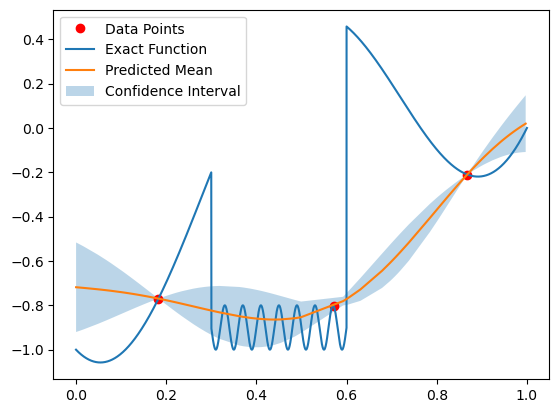

In [92]:
fig,ax = plt.subplots()



In [74]:
x_plot

array([8673.69312641])

In [9]:
from scipy.io import loadmat

wo_data = loadmat(folder+"wo_bag_final.mat")
regret_wo = wo_data['regret_DGPUCB']


wb_data = loadmat(folder+"wb_bag_final.mat")
regret_wb = wb_data['regret_DGPUCB']

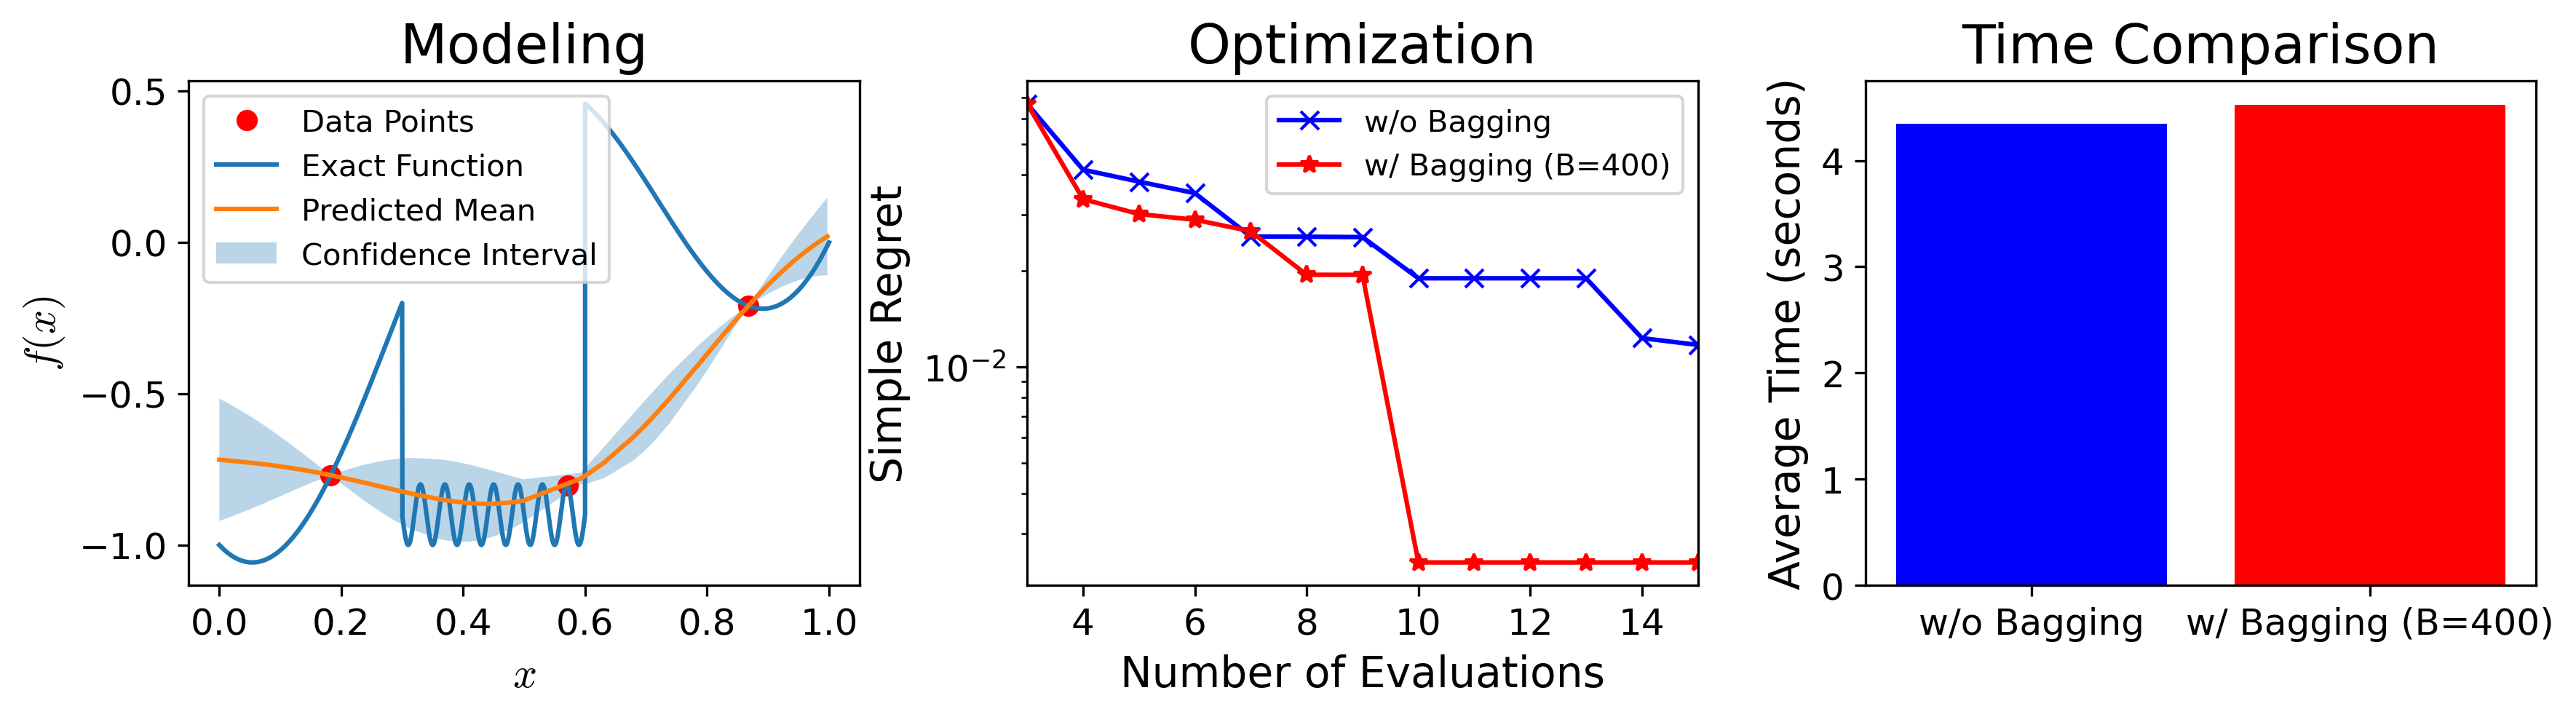

In [156]:
import matplotlib.pyplot as plt
shift = 0.00005

fig,axs = plt.subplots(1,3,figsize=(15, 15))

fig.dpi = 300

a = 10
b = 3

ax = axs[0]
# ax.set_aspect(0.5)
ax.figure.set_size_inches(a,b)
x_plot = np.sort(np.random.uniform(size = (10000,)))
ax.plot(x,f(x),'ro',label = 'Data Points')
ax.plot(x_plot,f(x_plot),label = "Exact Function")

ax.plot(xx_sort,mu[idx]*y_std,label = 'Predicted Mean')
ax.fill_between(xx_sort,(mu[idx] - 1.96*np.sqrt(var[idx]))*y_std,(mu[idx] + 1.96*np.sqrt(var[idx]))*y_std,alpha=0.3,label = 'Confidence Interval')
ax.legend(loc = 0)

# ax.set_yscale('log')
ax.set_ylabel('$f(x)$',fontsize = 14,math_fontfamily='cm')
ax.set_xlabel('$x$',fontsize=14,math_fontfamily='cm')
ax.set_title('Modeling',fontsize = 18)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)
ax.set_rasterized(True)

ax = axs[1]
# ax.set_aspect(5.8)
ax.figure.set_size_inches(a,b)
ax.plot(range(1,16),np.mean(regret_wo,axis= 0)+shift,'-x',color ='b',label = 'w/o Bagging')
ax.plot(range(1,16),np.mean(regret_wb,axis= 0)+shift,'-*',color = 'r',label = 'w/ Bagging (B=400)')

ax.set_xlim([3,15])


ax.legend(loc =1)
ax.set_yscale('log')
ax.set_ylabel('Simple Regret',fontsize = 14)
ax.set_xlabel('Number of Evaluations',fontsize=14)
ax.set_title('Optimization',fontsize = 18)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)
ax.set_rasterized(True)


ax = axs[2]
# ax.set_aspect(0.3)
ax.figure.set_size_inches(a,b)
ax.bar(['w/o Bagging','w/ Bagging (B=400)'],[time_wo,time_wb],color = ['b','r'])

# ax.set_yscale('log')
ax.set_ylabel('Average Time (seconds)',fontsize = 14)
# ax.set_xlabel('Number of Evaluations',fontsize=14)
ax.set_title('Time Comparison',fontsize = 18)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)
ax.set_rasterized(True)

fig.subplots_adjust(right=1.2,wspace = 0.25)
plt.savefig('BagvsNoBag_1D.pdf', format='pdf',pad_inches=0, bbox_inches='tight')

In [32]:
time_wo = np.mean(wo_data['runtime_DGPUCB'][:,3:])
time_wb = np.mean(wb_data['runtime_DGPUCB'][:,3:])

In [31]:
time_wo

array([[5.02895117, 4.23932576, 4.36413121, 4.02061534, 4.31964135,
        4.38496017, 4.39433432, 4.4589951 , 4.2856791 , 4.45244265,
        4.40584517, 4.52229381],
       [4.68390465, 4.26170349, 4.14991474, 4.23102546, 4.27603173,
        4.33290887, 4.38544273, 4.36468625, 4.22552514, 4.27980804,
        4.37635612, 4.1652956 ],
       [4.83376479, 4.27127576, 4.17710686, 4.19186544, 4.36201167,
        4.27499342, 4.26263905, 4.21091723, 4.12636137, 4.2629261 ,
        4.47184825, 4.27227783],
       [4.7397871 , 4.19510603, 4.36839676, 4.26154232, 4.23280454,
        4.30558372, 4.21210265, 4.21559143, 4.33827162, 4.44141555,
        4.29644442, 4.2324996 ],
       [4.95167542, 4.36468887, 4.35158134, 4.24365616, 4.18902111,
        4.2809844 , 4.35215521, 4.3806932 , 4.33103085, 4.32800984,
        4.33847046, 4.33489656]])

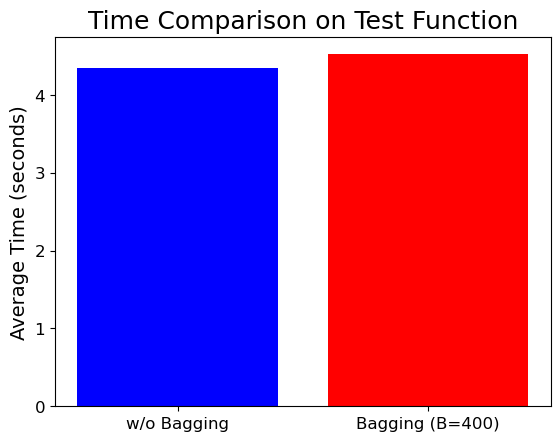

In [38]:
fig,ax = plt.subplots()
